# Experiments with Fitzpatrick17K

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import torch # Due to keras version
import tensorflow as tf
import imageprocessing
from imageprocessing import ImageResize, MaskedImage
import kerasmodels
from kerasmodels import CreateGenerator
import attacks
import preprocess_ham
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

2024-07-31 11:21:19.303514: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 11:21:19.329351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 11:21:20.128065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


## Load data

In [2]:
db = "FITZ"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [3]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create image generator

In [4]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [5]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 864 validated image filenames belonging to 2 classes.
Found 864 validated image filenames belonging to 2 classes.


## Training

2024-07-31 11:21:21.700403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 11:21:21.701884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 11:21:21.701914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 11:21:21.705139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 11:21:21.705173: I external/local_xla/xla/stream_executor

Epoch 1/20


/home/kuniko/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722421300.935960  356896 service.cc:145] XLA service 0x7ff0b8007a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722421300.936039  356896 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-31 11:21:40.981907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 11:21:41.221272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


  4/250 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.2917 - loss: 1.1505  

I0000 00:00:1722421304.257852  356896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.5438 - loss: 0.8227 - val_accuracy: 0.5509 - val_loss: 0.7530
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.5875 - loss: 0.6860 - val_accuracy: 0.5637 - val_loss: 1.0011
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6284 - loss: 0.6580 - val_accuracy: 0.5938 - val_loss: 0.7142
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6335 - loss: 0.6403 - val_accuracy: 0.6123 - val_loss: 0.7126
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.6817 - loss: 0.5937 - val_accuracy: 0.6007 - val_loss: 0.7262
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6702 - loss: 0.6057 - val_accuracy: 0.6250 - val_loss: 0.6944
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6949 - loss: 0.5973 - val_accuracy: 0.6192 - val_loss: 0.6969
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6658 - loss: 0.5930 - val_accurac

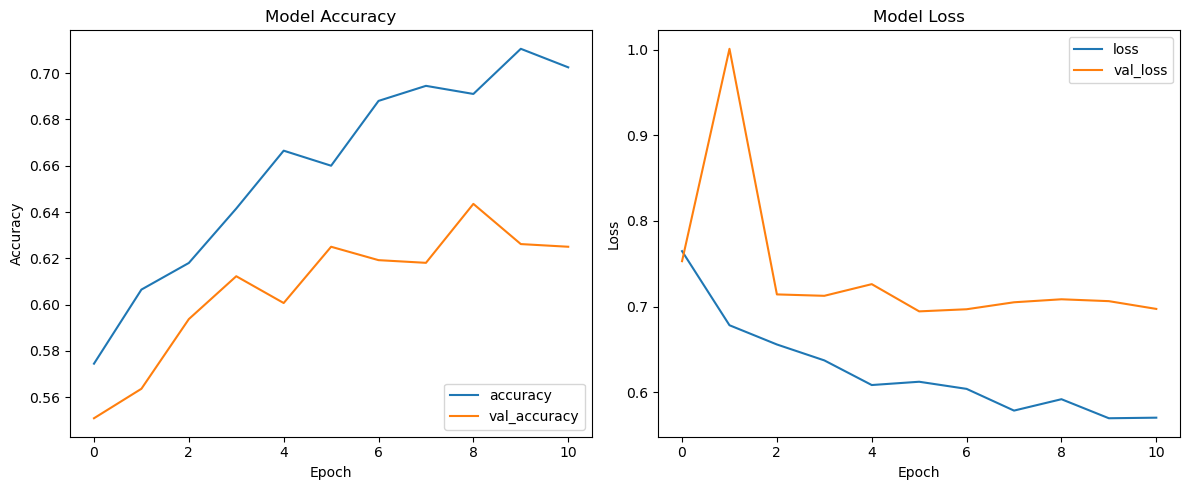

In [6]:
import keras
keras.utils.set_random_seed(42)

epochs = 20
patience = 5
start_from_epoch = 5
callback = tf.keras.callbacks.EarlyStopping(patience=patience, start_from_epoch=start_from_epoch, restore_best_weights=True)

learning_rate=0.00001
model = kerasmodels.make_cnn_model(learning_rate)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])
kerasmodels.plot_training_results(history)

## Evaluation

In [7]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6110 - loss: 0.6709
Test Loss 0.6835697889328003
Test Accuracy 0.6030092835426331


In [8]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58       432
           1       0.59      0.66      0.62       432

    accuracy                           0.60       864
   macro avg       0.60      0.60      0.60       864
weighted avg       0.60      0.60      0.60       864



# Adversarial attacks

## Random Noise

True label: 1
Prediction: [[0.7894824]]
Prediction class: ['1']
Adversarial Prediction: [[0.34601182]]
Adversarial Predicted Class: ['0']


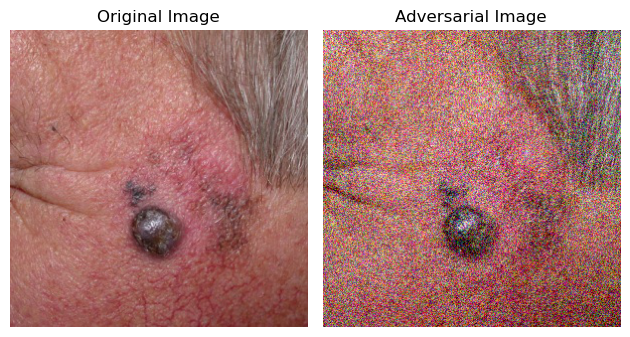

In [9]:
np.random.seed(42)
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.3
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [10]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [11]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.2638888888888889
RN FP Success rate: 0.18287037037037038
RN FN Success rate: 0.08101851851851852


## FGSM

True label: 1
Prediction: [[0.7894824]]
Prediction class: ['1']
Adversarial Prediction: [[0.00014368]]
Adversarial Predicted Class: ['0']


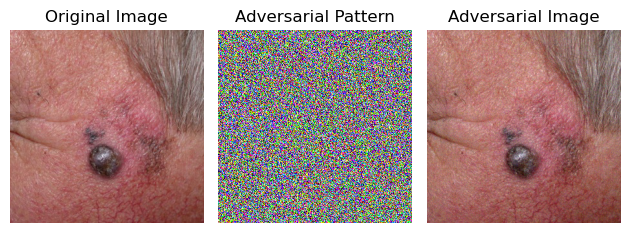

In [12]:
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.03
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [13]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [14]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.5983796296296297
FGSM FP Success rate: 0.2708333333333333
FGSM FN Success rate: 0.3275462962962963


## Saliency Map Attack

True label: 1
Prediction: [[0.7894824]]
Prediction class: ['1']
Adversarial Prediction: [[0.66183716]]
Adversarial Predicted Class: ['1']


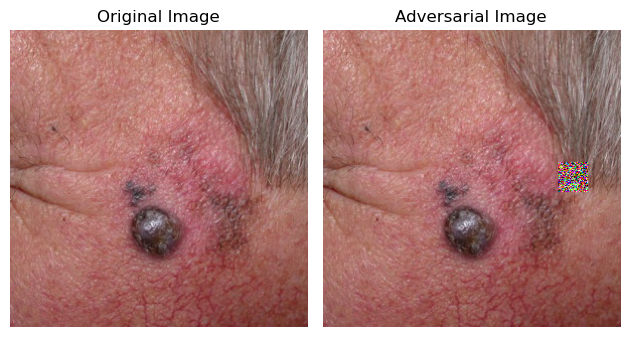

In [15]:
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.8
patch_size=30
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [16]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [17]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.17708333333333334
SM FP Success rate: 0.1261574074074074
SM FN Success rate: 0.05092592592592592


## Data export for analysis

In [18]:
test_df.to_csv(f"{root}exp/test_df_Fitzpatrick17K_CNN.csv", index=False)